# B1, b2, b3 Comparison: 200 GeV Extended vs 26 GeV Extended

## Objective

Compare the main field **B1** (T), normal quadrupole **b2** (units), and normal
sextupole **b3** (units) at two operating points:

- **Injection before MD1** (~301 A, 26 GeV) -- the MD1 injection plateau
- **Top of SFTPRO** (~4815 A, 400 GeV) -- the SFTPRO flat-top

for two measurement campaigns on the same SPS MBB dipole:

| Dataset | Path | Description |
|---------|------|-------------|
| **200 GeV extended** | `01_200_extended` | Extended measurement, 200 GeV cycle |
| **26 GeV extended** | `03_26_extended` | Extended measurement, 26 GeV cycle |

Both datasets share the supercycle structure **LHC_pilot -> MD1 -> SFTPRO**,
repeated ~20 times.

---
## 1. Configuration

In [1]:
# =====================================================================
#  USER-SELECTABLE PARAMETERS  --  edit this section before running
# =====================================================================

# --- 200 GeV Extended ---
SESSION_200 = "2026_02_06/01_200_extended/20260206_144537_SPS_MBB"
SUBDIR_200  = "20260206_144559_MBB"

# --- 26 GeV Extended ---
SESSION_26 = "2026_02_06/03_26_extended/20260206_151808_SPS_MBB"
SUBDIR_26  = "20260206_151827_MBB"

# --- Common ---
SEGMENT = "NCS"
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"
MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution
OPTIONS = ("dri", "rot", "cel", "fed")
PLATEAU_I_RANGE_MAX = 2.5 # A -- plateau detection threshold
MIN_B1_T = 1e-4           # minimum main field for normalization

print("B1 / b2 / b3 Comparison: 200 GeV vs 26 GeV Extended")
print("=" * 55)
print(f"  200 GeV : {SESSION_200}")
print(f"  26 GeV  : {SESSION_26}")
print(f"  Segment : {SEGMENT}")
print(f"  Plateau : I range < {PLATEAU_I_RANGE_MAX} A")

B1 / b2 / b3 Comparison: 200 GeV vs 26 GeV Extended
  200 GeV : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
  26 GeV  : 2026_02_06/03_26_extended/20260206_151808_SPS_MBB
  Segment : NCS
  Plateau : I range < 2.5 A


---
## 2. Imports

In [2]:
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

# Locate repo root
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    compute_block_averaged_range,
    detect_plateau_turns,
    classify_current,
    find_contiguous_groups,
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"
kn = load_segment_kn_txt(str(KN_PATH))
print(f"Kn loaded: {len(kn.orders)} harmonics from {KN_PATH.name}")
print("Imports ready.")

Kn loaded: 15 harmonics from Kn_values_Seg_Main_A_AC.txt
Imports ready.


---
## 3. Helper: Load & Process One Dataset

Processes **all plateau turns** (injection + flat-high + flat-mid) through the
Kn pipeline. Returns a DataFrame with `B1_T`, `b2_units`, `b3_units`, `label`,
etc.

In [3]:
Ns = SAMPLES_PER_TURN
m = MAGNET_ORDER
MAX_ZR = 0.01
N_BLOCKS = 10

FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)

ANALYSIS_LABELS = {"injection", "flat-mid", "flat-high"}


def load_and_process(session, meas_subdir, dataset_label=""):
    """Load one measurement session and return plateau-turn DataFrame."""
    session_dir = REPO_ROOT / "measurements" / session
    run_dir = session_dir / meas_subdir

    # Find NCS raw file
    ncs_files = []
    for f in sorted(run_dir.iterdir()):
        match = FILE_PAT.search(f.name)
        if match and match.group(3) == SEGMENT:
            ncs_files.append(f)
    assert ncs_files, f"No {SEGMENT} raw files found in {run_dir}"
    raw_file = ncs_files[0]
    print(f"\n{'='*60}")
    print(f"  Dataset: {dataset_label or session}")
    print(f"  Raw file: {raw_file.name}")

    # Load raw data
    raw = np.loadtxt(raw_file)
    n_turns = raw.shape[0] // Ns
    n_keep = n_turns * Ns
    print(f"  Shape: {raw.shape} -> {n_turns} turns")
    print(f"  Time span: {raw[-1,0] - raw[0,0]:.1f} s ({(raw[-1,0] - raw[0,0])/60:.1f} min)")

    # Reshape into (n_turns, Ns)
    t_all = raw[:n_keep, 0].reshape(n_turns, Ns)
    flux_abs_all = raw[:n_keep, 1].reshape(n_turns, Ns)
    flux_cmp_all = raw[:n_keep, 2].reshape(n_turns, Ns)
    I_all = raw[:n_keep, 3].reshape(n_turns, Ns)

    # Auto-detect channel swap
    I_mean_quick = I_all.mean(axis=1)
    best_turn = np.argmax(np.abs(I_mean_quick))
    r1 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 1])
    r2 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 2])
    swap = (r2 > r1)
    if swap:
        flux_abs_all = raw[:n_keep, 2].reshape(n_turns, Ns)
        flux_cmp_all = raw[:n_keep, 1].reshape(n_turns, Ns)
        print("  (flux columns swapped)")

    # Per-turn statistics
    I_mean = I_all.mean(axis=1)
    t_mean = t_all.mean(axis=1)
    I_range, I_blocks = compute_block_averaged_range(I_all, Ns, N_BLOCKS)

    # Plateau detection
    plateau_info = detect_plateau_turns(I_blocks, I_mean, I_range, PLATEAU_I_RANGE_MAX)
    is_plateau = plateau_info["is_plateau"]

    # Classify current levels
    turn_label = np.array(["ramp"] * n_turns, dtype=object)
    for i in range(n_turns):
        if is_plateau[i]:
            turn_label[i] = classify_current(I_mean[i])

    # Summary
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = turn_label == lab
        n = mask.sum()
        if n > 0:
            print(f"  {lab:12s}: {n:4d} turns, I = {I_mean[mask].mean():.1f} +/- {I_mean[mask].std():.1f} A")

    # Process all plateau turns through Kn pipeline
    is_analysis = np.array([l in ANALYSIS_LABELS for l in turn_label])
    plateau_indices = np.where(is_analysis)[0]
    print(f"  Processing {len(plateau_indices)} plateau turns...")

    if len(plateau_indices) == 0:
        print("  WARNING: no plateau turns found!")
        return pd.DataFrame(), t_mean, I_mean, turn_label, is_plateau

    idx = plateau_indices
    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=flux_abs_all[idx],
        flux_cmp_turns=flux_cmp_all[idx],
        t_turns=t_all[idx],
        I_turns=I_all[idx],
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    extra = [
        {
            "global_turn": int(idx[t]),
            "label": str(turn_label[idx[t]]),
            "I_range_A": float(I_range[idx[t]]),
        }
        for t in range(len(idx))
    ]

    rows = build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)
    df = pd.DataFrame(rows)

    print(f"  Processed: {len(df)} turns")
    for lab in ["injection", "flat-mid", "flat-high"]:
        sub = df[df["label"] == lab]
        if len(sub) > 0:
            print(f"    {lab:12s}: {len(sub):4d} turns, "
                  f"B1 = {sub['B1_T'].mean():.6f} T, "
                  f"b3 = {sub['b3_units'].mean():+.3f} units")

    return df, t_mean, I_mean, turn_label, is_plateau

---
## 4. Load Both Datasets

In [4]:
df_200, t_200, I_200, lbl_200, plat_200 = load_and_process(
    SESSION_200, SUBDIR_200, "200 GeV Extended (01_200_extended)"
)

df_26, t_26, I_26, lbl_26, plat_26 = load_and_process(
    SESSION_26, SUBDIR_26, "26 GeV Extended (03_26_extended)"
)


  Dataset: 200 GeV Extended (01_200_extended)
  Raw file: 20260206_144559_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
  Shape: (1086464, 5) -> 1061 turns
  Time span: 1061.0 s (17.7 min)
  injection   :  488 turns, I = 300.9 +/- 0.2 A
  flat-high   :   74 turns, I = 4814.5 +/- 1.8 A
  Processing 562 plateau turns...
  Processed: 562 turns
    injection   :  488 turns, B1 = 0.115640 T, b3 = +0.177 units
    flat-high   :   74 turns, B1 = 1.793702 T, b3 = +0.344 units

  Dataset: 26 GeV Extended (03_26_extended)
  Raw file: 20260206_151827_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
  Shape: (1089536, 5) -> 1064 turns
  Time span: 1064.0 s (17.7 min)
  injection   :  520 turns, I = 300.9 +/- 0.2 A
  flat-high   :   72 turns, I = 4814.5 +/- 1.8 A
  Processing 592 plateau turns...
  Processed: 592 turns
    injection   :  520 turns, B1 = 0.115644 T, b3 = +0.198 units
    flat-high   :   72 turns, B1 = 1.793809 T, b3 = +0.355 units


---
## 5. Current Profile Overview

Side-by-side current profiles with plateau turns colour-coded.

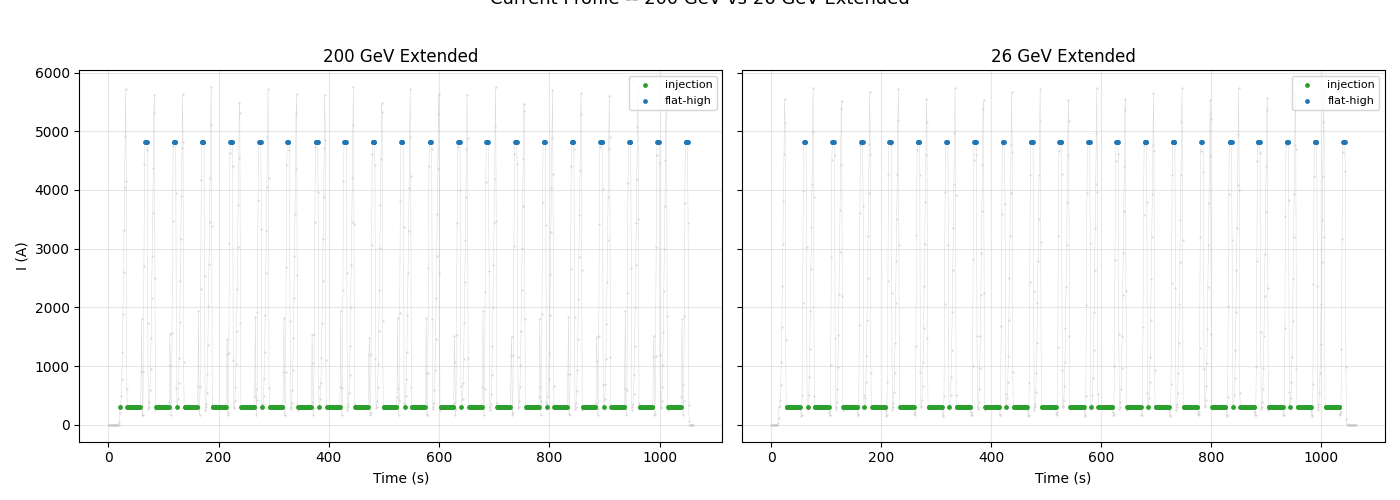

In [5]:
label_colors = {
    "injection": "tab:green",
    "flat-mid": "tab:purple",
    "flat-high": "tab:blue",
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, t_m, I_m, lbl, plat, title in [
    (axes[0], t_200, I_200, lbl_200, plat_200, "200 GeV Extended"),
    (axes[1], t_26, I_26, lbl_26, plat_26, "26 GeV Extended"),
]:
    ax.plot(t_m, I_m, ".-", markersize=1, linewidth=0.3,
            color="lightgrey", zorder=0)

    for lab, col in label_colors.items():
        mask = lbl == lab
        idx = np.where(mask)[0]
        if len(idx) > 0:
            ax.scatter(t_m[idx], I_m[idx], s=6, color=col,
                       zorder=2, label=lab)

    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    ax.legend(fontsize=8, loc="upper right")

axes[0].set_ylabel("I (A)")
fig.suptitle("Current Profile -- 200 GeV vs 26 GeV Extended",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Summary Statistics Table

Mean +/- std of B1, b2, b3 at each operating point for both datasets.

In [6]:
# Build summary table
summary_rows = []

for ds_name, df in [("200 GeV", df_200), ("26 GeV", df_26)]:
    for lab, desc in [("injection", "Injection (MD1)"),
                      ("flat-high", "Top of SFTPRO")]:
        sub = df[(df["label"] == lab) & df["ok_main"]]
        if len(sub) == 0:
            continue
        summary_rows.append({
            "Dataset": ds_name,
            "Operating point": desc,
            "N turns": len(sub),
            "I mean (A)": f"{sub['I_mean_A'].mean():.1f}",
            "B1 mean (T)": f"{sub['B1_T'].mean():.6f}",
            "B1 std (T)": f"{sub['B1_T'].std():.6f}",
            "b2 mean (units)": f"{sub['b2_units'].mean():+.4f}",
            "b2 std (units)": f"{sub['b2_units'].std():.4f}",
            "b3 mean (units)": f"{sub['b3_units'].mean():+.4f}",
            "b3 std (units)": f"{sub['b3_units'].std():.4f}",
        })

df_summary = pd.DataFrame(summary_rows)
print(df_summary.to_string(index=False))

Dataset Operating point  N turns I mean (A) B1 mean (T) B1 std (T) b2 mean (units) b2 std (units) b3 mean (units) b3 std (units)
200 GeV Injection (MD1)      488      300.9    0.115640   0.000066         -1.1287         0.1645         +0.1772         0.0612
200 GeV   Top of SFTPRO       74     4814.5    1.793702   0.000483         -0.9453         0.0570         +0.3439         0.0415
 26 GeV Injection (MD1)      520      300.9    0.115644   0.000094         -1.1258         0.1706         +0.1978         0.0591
 26 GeV   Top of SFTPRO       72     4814.5    1.793809   0.000467         -0.9637         0.0646         +0.3552         0.0417


---
## 7. B1 Comparison: Injection vs SFTPRO Flat-Top

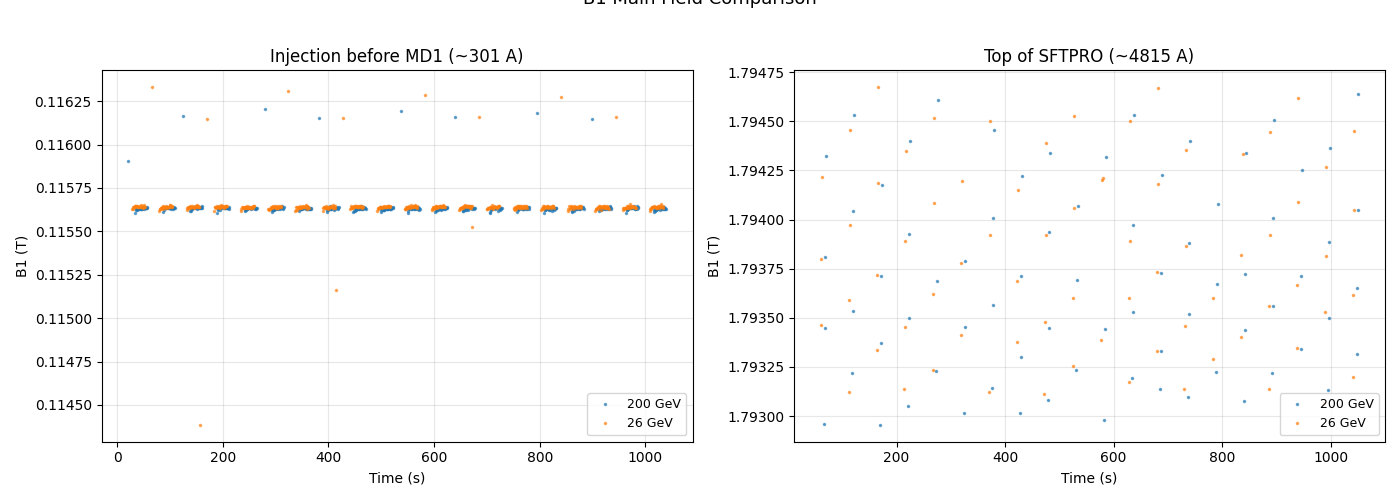

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", "Injection before MD1 (~301 A)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, df, col in [("200 GeV", df_200, "tab:blue"),
                              ("26 GeV", df_26, "tab:orange")]:
        sub = df[(df["label"] == lab) & df["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["B1_T"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("B1 Main Field Comparison", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 8. b2 Comparison: Injection vs SFTPRO Flat-Top

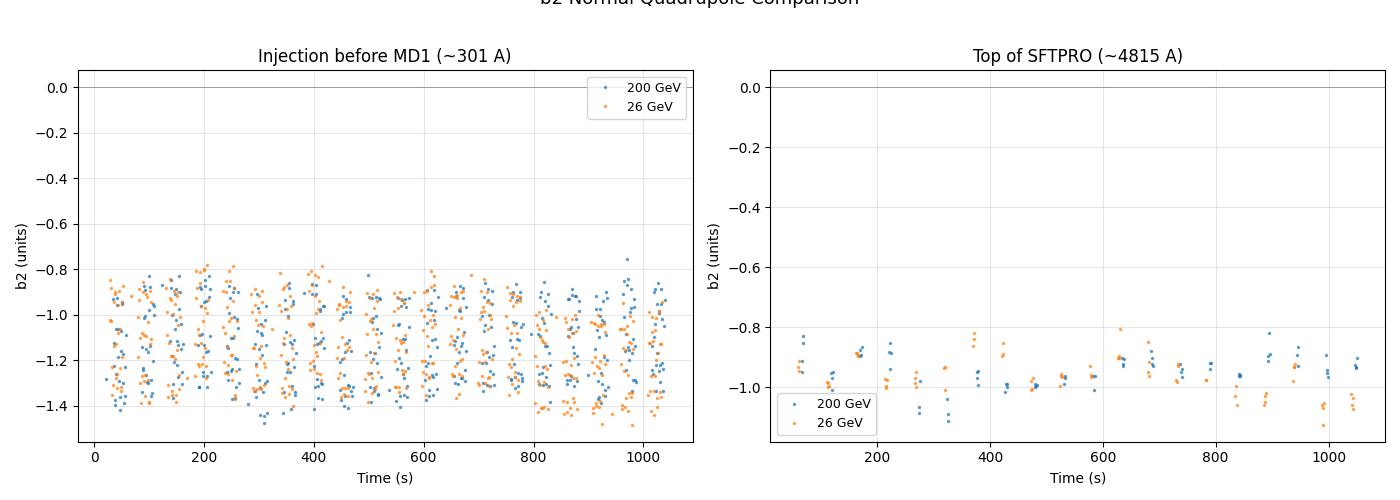

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", "Injection before MD1 (~301 A)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, df, col in [("200 GeV", df_200, "tab:blue"),
                              ("26 GeV", df_26, "tab:orange")]:
        sub = df[(df["label"] == lab) & df["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["b2_units"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b2 (units)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("b2 Normal Quadrupole Comparison", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 9. b3 Comparison: Injection vs SFTPRO Flat-Top

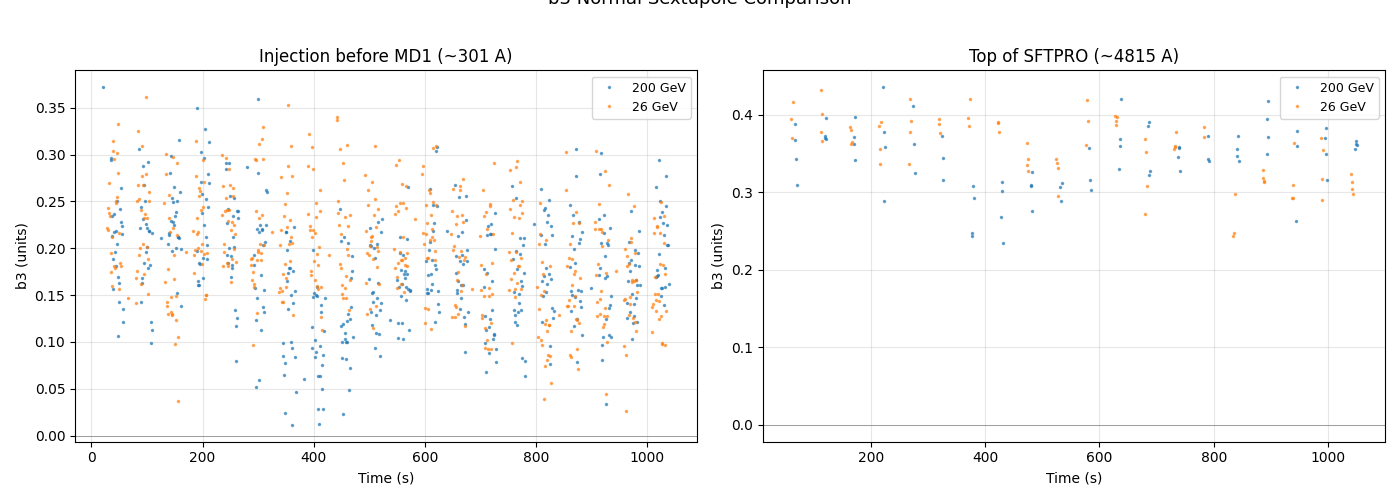

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", "Injection before MD1 (~301 A)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, df, col in [("200 GeV", df_200, "tab:blue"),
                              ("26 GeV", df_26, "tab:orange")]:
        sub = df[(df["label"] == lab) & df["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["b3_units"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("b3 Normal Sextupole Comparison", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 10. Box Plots: B1, b2, b3 by Dataset and Operating Point

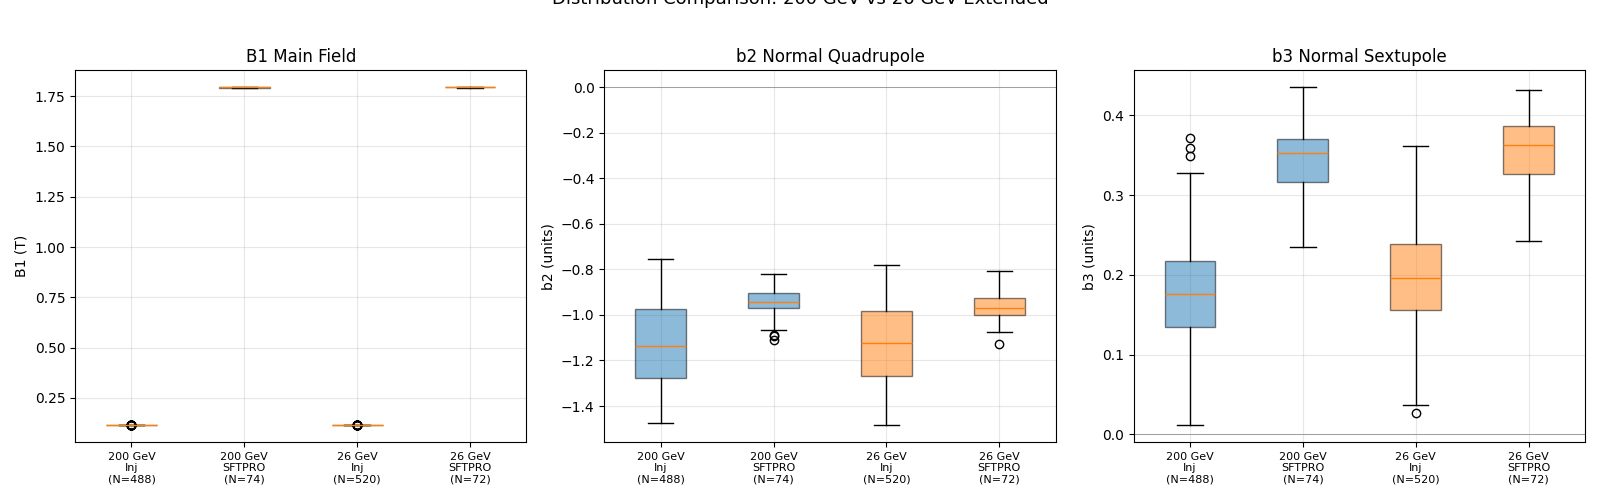

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col_name, ylabel, title in [
    (axes[0], "B1_T", "B1 (T)", "B1 Main Field"),
    (axes[1], "b2_units", "b2 (units)", "b2 Normal Quadrupole"),
    (axes[2], "b3_units", "b3 (units)", "b3 Normal Sextupole"),
]:
    box_data = []
    box_labels = []
    box_colors = []

    for ds_name, df, base_col in [("200 GeV", df_200, "tab:blue"),
                                   ("26 GeV", df_26, "tab:orange")]:
        for lab, short in [("injection", "Inj"), ("flat-high", "SFTPRO")]:
            sub = df[(df["label"] == lab) & df["ok_main"]]
            if len(sub) == 0:
                continue
            box_data.append(sub[col_name].values)
            box_labels.append(f"{ds_name}\n{short}\n(N={len(sub)})")
            box_colors.append(base_col)

    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
        for patch, col in zip(bp["boxes"], box_colors):
            patch.set_facecolor(col)
            patch.set_alpha(0.5)

    if col_name != "B1_T":
        ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis="x", labelsize=8)

fig.suptitle("Distribution Comparison: 200 GeV vs 26 GeV Extended",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 11. Bar Chart: Mean Values with Error Bars

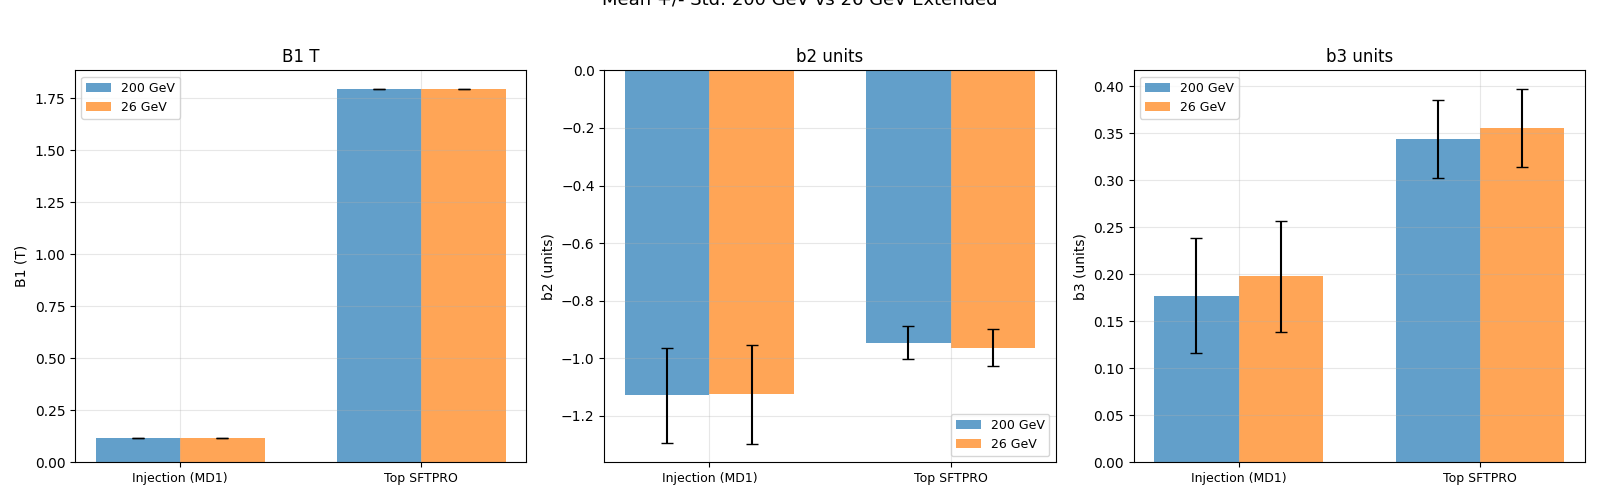

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

datasets = [("200 GeV", df_200), ("26 GeV", df_26)]
op_points = [("injection", "Injection (MD1)"), ("flat-high", "Top SFTPRO")]
colors_ds = {"200 GeV": "tab:blue", "26 GeV": "tab:orange"}
harmonics = [("B1_T", "B1 (T)"), ("b2_units", "b2 (units)"), ("b3_units", "b3 (units)")]

x = np.arange(len(op_points))
width = 0.35

for ax, (col_name, ylabel) in zip(axes, harmonics):
    for i, (ds_name, df) in enumerate(datasets):
        means = []
        stds = []
        for lab, _ in op_points:
            sub = df[(df["label"] == lab) & df["ok_main"]]
            if len(sub) > 0:
                means.append(sub[col_name].mean())
                stds.append(sub[col_name].std())
            else:
                means.append(0)
                stds.append(0)

        offset = (i - 0.5) * width
        ax.bar(x + offset, means, width, yerr=stds, capsize=4,
               color=colors_ds[ds_name], alpha=0.7, label=ds_name)

    ax.set_xticks(x)
    ax.set_xticklabels([desc for _, desc in op_points], fontsize=9)
    ax.set_ylabel(ylabel)
    ax.set_title(col_name.replace("_", " "))
    ax.legend(fontsize=9)

fig.suptitle("Mean +/- Std: 200 GeV vs 26 GeV Extended",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 12. Difference Table (200 GeV - 26 GeV)

In [12]:
print("Difference: (200 GeV) - (26 GeV)")
print("=" * 80)
print(f"{'Operating Point':>20s}  {'dB1 (T)':>12s}  {'db2 (units)':>14s}  {'db3 (units)':>14s}")
print("-" * 80)

for lab, desc in [("injection", "Injection (MD1)"),
                  ("flat-high", "Top of SFTPRO")]:
    s200 = df_200[(df_200["label"] == lab) & df_200["ok_main"]]
    s26 = df_26[(df_26["label"] == lab) & df_26["ok_main"]]

    if len(s200) == 0 or len(s26) == 0:
        print(f"{desc:>20s}  {'N/A':>12s}  {'N/A':>14s}  {'N/A':>14s}")
        continue

    dB1 = s200["B1_T"].mean() - s26["B1_T"].mean()
    db2 = s200["b2_units"].mean() - s26["b2_units"].mean()
    db3 = s200["b3_units"].mean() - s26["b3_units"].mean()

    # Propagated uncertainty (std of mean)
    dB1_err = np.sqrt((s200["B1_T"].std()**2 / len(s200)) +
                      (s26["B1_T"].std()**2 / len(s26)))
    db2_err = np.sqrt((s200["b2_units"].std()**2 / len(s200)) +
                      (s26["b2_units"].std()**2 / len(s26)))
    db3_err = np.sqrt((s200["b3_units"].std()**2 / len(s200)) +
                      (s26["b3_units"].std()**2 / len(s26)))

    print(f"{desc:>20s}  {dB1:+.6f}+/-{dB1_err:.6f}  "
          f"{db2:+.4f}+/-{db2_err:.4f}  {db3:+.4f}+/-{db3_err:.4f}")

Difference: (200 GeV) - (26 GeV)
     Operating Point       dB1 (T)     db2 (units)     db3 (units)
--------------------------------------------------------------------------------
     Injection (MD1)  -0.000005+/-0.000005  -0.0029+/-0.0106  -0.0206+/-0.0038
       Top of SFTPRO  -0.000107+/-0.000079  +0.0185+/-0.0101  -0.0114+/-0.0069


---
## 13. Export

In [13]:
out_dir = REPO_ROOT / "output" / "2026_02_06" / "compare_200_vs_26"
out_dir.mkdir(parents=True, exist_ok=True)

for name, df in [("200GeV", df_200), ("26GeV", df_26)]:
    if len(df) > 0:
        fname = f"plateau_harmonics_{name}.csv"
        df.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(df)} rows)")

if len(df_summary) > 0:
    fname = "summary_comparison.csv"
    df_summary.to_csv(out_dir / fname, index=False)
    print(f"Wrote {out_dir / fname}  ({len(df_summary)} rows)")

print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_200GeV.csv  (562 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_26GeV.csv  (592 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\summary_comparison.csv  (4 rows)

Done.
